<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Rafael Gallardo Vázquez y Paulo Adrián Villa Domínguez.

**Fecha:** 16 de febrero del 2023.

**Expediente** : 736376 y 733773.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/G4ll4rd0/Tarea3_RGALLARDO_PAVILLA)

# Tarea 3: Clase 7

## Enunciado de tarea 
Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:


    class LinearForecast:
        def __init__(self, atributos_del_contructor):
            
        def adf_test(self):
            
        def plot_acf_pac(self):
            
            .
            .
            . 

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
import itertools
from sklearn.preprocessing import power_transform
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

import warnings
warnings.filterwarnings("ignore")

### Ejercicio 1: Creación de la Clase

Código de solución estudiante 1

In [2]:
# Código de solución estudiante 1

class LinearForecastStudent1:

    #Inicializador
    def __init__(self, data):
        self.data = data

    #Dataset
    def setTimeSeries(self, target, dateColumn = 'date'):
        '''Generates the timeseries to use for the analysis in this class

        Args:
            target (str): target column of our dataset
            dateColumn (str, optional): Date column in the dataset, please . Defaults to 'date'.

        Returns:
            DataFrame: returns timeseries tail so user can verify it's correct
        '''
        timeseries = self.data[[dateColumn, target]]
        timeseries.columns = ['date', 'y']
        timeseries['date'] = pd.to_datetime(timeseries['date'])
        timeseries = timeseries.set_index('date').resample('M').mean()
        self.timeseries = timeseries
        self.toUse = timeseries
        return self.timeseries.tail()

    #Tamaño a Analizar
    def setTimeSeriesSlice(self, fraction = 400):
        '''Sets a slice to only analyze that in the timeseries

        Args:
            fraction (int, optional): Slice to use for analysis. Defaults to 400.
        '''
        self.slice = fraction
        self.fraction = self.timeseries[:fraction]
        self.toUse = self.fraction

    # Visualizar Serie de Tiempo
    def plotTimeSeries(self):
        '''Plots the time series, either the full one or the slice if we have set one

        Returns:
            Plot: Visual plot
        '''
        return self.toUse.plot()

    #ADF
    def adf_test(self, useSelf = True, extra = ''):
        '''Generates Dickey-Fuller Test for our target timeseries

        Args:
            useTrue (bool, optional): If it should be used with the self.timeseries or with the one provided by extra. Defaults to True
            extra (__type__, optional): Timeseries to use in case we don't want to use self. Defaults to ''
        '''
        print("Results of Dickey-Fuller Test:")
        if useSelf:
            series = self.timeseries
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    # Graficar ACF y PACF
    def plot_acf_pacf(self, withDiff = 0, kwargs={'lags' : 40}, useSelf = True, extra = ''):
        '''Plots ACF and PACF with the amount of diffs desired

        Args:
            withDiff (int, optional): Amount of Diffs desired to use. Defaults to 0.
            kwargs (_type_, optional): Normaly used to lags. Defaults to dict().
            useTrue (bool, optional): If it should be used with the self.timeseries or with the one provided by extra. Defaults to True
            extra (__type__, optional): Timeseries to use in case we don't want to use self. Defaults to ''
        '''
        f = plt.figure(figsize=(8,5))

        if useSelf:
            series = self.toUse
        else:
            series = extra

        for _ in range(withDiff):
            series = series.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(series, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    #Función para analisis de estacionalidad
    def seasonalDecompose(self, seasonality):
        '''Creates the Seasonal Decompose for stacionality analysys of our timeseries

        Args:
            seasonality (tuple): Recieves the parameters in wich our acf graphic shows it's stational
        '''
        self.seasonality = seasonality
        data1 = self.timeseries.copy()
        periods_seasonality = self.seasonality

        stl_kwargs = {"seasonal_deg": 0} 
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        self.res2 = res2

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        ax = res2.observed.to_frame('observados')[:self.slice].plot()

        res2.seasonal[:self.slice].plot(ax = ax)

    #Determinar Parametros
    def checkStationary(self):
        '''Checks ADF and ACF & PACF graphics for the chosen stationalities
        '''
        j = {}
        for i in self.seasonality:
            h = f'seasonal_{i}'
            print(h, '\n')
            j[h] = self.res2.seasonal[h]
            self.adf_test(useSelf = False, extra = j[h])
            print('Non-differentiated')
            self.plot_acf_pacf(useSelf = False, extra = j[h])
            print('Differentiated')
            self.plot_acf_pacf(withDiff=1, useSelf = False, extra = j[h])
            print('\n\n\n')
        self.j = j

    #Componente no estacional
    def nonStationalComponent(self, seasonality):
        '''Creates graphic for the non-Stational component using the chosen stationality

        Args:
            seasonality (int): Chosen seasonality of those tried
        '''
        self.adf_test(useSelf=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasonality}']
        non_seasonal.plot()
        self.adf_test(useSelf=False, extra = non_seasonal)
        print('Non-differentiated')
        self.plot_acf_pacf(useSelf = False, extra = non_seasonal)
        print('Differentiated')
        self.plot_acf_pacf(withDiff=1, useSelf = False, extra = non_seasonal)
        print('Differentiated x2')
        self.plot_acf_pacf(withDiff=2, useSelf = False, extra = non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosenSeasonality = seasonality

    #Combinaciones de parametros
    def sarimaxParameters(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):
        '''Creates posible paramter configurations for our sarima model

        Args:
            p (list): p component
            d (list): d component
            q (list): q component
            P (list): P component
            D (list): D component
            Q (list): Q component
            t (list, optional): Trend. Defaults to ['n', 'c', 't', 'ct'].
        '''
        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], self.chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        # Diferentes conmbinaciones
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    #Escalamiento de datos
    def scaleData(self):
        '''Scales data using yeo-jhonson
        '''
        vals = power_transform(self.timeseries['y'].to_numpy().reshape(-1, 1), method='yeo-johnson')
        self.scaledData = vals
    
    #Encontrar parametros optimos
    def findParams(self):
        '''Creates multiple iterations of our SARIMAX model using the proposed parameters to find thos that better suit our model

        Returns:
            DataFrame: dataframe containing the performance of the model using AIC, BIC, LLF
        '''
        self.scaleData()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))

        print(f'Trying out {len(self.sarimax_params)} posible combinations')

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= par_no_season,
                seasonal_order= par_season
            )
            results = mod.fit()

            print(f'Model done for params: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams

    #Reentrenar con los mejores parametros
    def sarimaxModel(self, no_season, season, trend):
        '''Retrains a SARIMAX model with the chosen parameters of previus iterations

        Args:
            no_season (tuple): Non-Seasonal parameters chosen for our model
            season (tuple): Seasonal Parameters chosen for our model
            trend (string): Trend chosen for our model

        Returns:
            Summary: Summary of the trained SARIMAX model
        '''
        model = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= no_season,
                seasonal_order= season,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        results = model.fit()
        self.sarimax = results
        return results.summary()

    #Predicción
    def prediction(self, size):
        end = len(self.timeseries)
        start = end-size
        actual = self.scaledData[start:end]
        predicted = self.sarimax.predict(start = start+1, end = end, dynamic = True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape

        self.actual = actual
        self.predicted = predicted

        predictions = pd.DataFrame({'actual': actual, 'predicted': predicted}, index=self.timeseries.index[start:end])

        fig, ax = plt.subplots(figsize=(12,8))
        predictions.actual.plot(ax = ax)
        predictions.predicted.plot(ax =ax)
        ax.legend(labels = ['actual', 'forecast'])

    #MAPE
    def calculate_mape(self) -> float:
        # Convert actual and predicted
        # to numpy array data type if not already
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        # Calculate the MAPE value and return
        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    #MAD
    def calculate_mad(self) -> float:
        # Convert actual and predicted
        # to numpy array data type if not already
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        # Calculate the MAPE value and return
        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

    #Métricas de error
    def errors(self):
        self.calculate_mape()
        self.calculate_mad()
        print(f'MAPE: {self.mape} \n MAD: {self.mad}')


Código de solución estudiante 2

In [3]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


class LinearForecast:
    def __init__(self, timeseries):
        self.timeseries = timeseries

    @staticmethod
    def evaluate_forecasts(actual, predicted):
        """
        Función que se encargará de calcular las métricas de error. (MSE, RMSE, MAD, MAPE)
        :param actual: Valor actual de la serie de tiempo que se desea predecir.
        :param predicted: Valor predicho por el modelo ajustado.
        """
        # Mean Squared Error (MSE)
        mse_metric = np.mean((predicted - actual) ** 2)
        # Root Mean Squared Error (RMSE)
        rmse_metric = np.sqrt(mse_metric)
        # Mean Absolute Percentage Error (MAPE)
        mape_metric = np.mean(np.abs((actual - predicted) / actual)) * 100
        # Mean Absolute Deviation (MAD)
        mad_metric = np.mean(np.abs(predicted - actual))
        return mse_metric, rmse_metric, mape_metric, mad_metric

    def split_dataset(self, train_size: float):
        """
        Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
        :param train_size: Tamaño de la division del dataset de entrenamiento (0, 1).
        """
        split = int(np.round(self.timeseries.shape[0] * train_size))
        train_data = self.timeseries[:split]
        test_data = self.timeseries[split:]
        return train_data, test_data

    def plot_acf_pacf(self, kwargs: dict):
        """
        Función que grafica las funciones de autocorrelación y autocorrelación parcial,
        depende de matplotlib y plot_acf, plot_pacf (statsmodels).
        :param kwargs: Argumentos de las funciones de statsmodels
        :return: Gráficas de acf y pacf
        """
        f = plt.figure(figsize=(8, 5))
        ax1 = f.add_subplot(121)
        plot_acf(self.timeseries, zero=False, ax=ax1, **kwargs)
        ax2 = f.add_subplot(122)
        plot_pacf(self.timeseries, zero=False, ax=ax2, method='ols', **kwargs)
        plt.show()

    def adf_test(self):
        """
        Se calcula si la serie de tiempo es estacionaria con el test de "Dickey-Fuller"
        :return: Simplemente un "print" que nos dice si la serie es estacionaria o no.
        """
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.timeseries, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    @staticmethod
    def model_forecast(time_series, horizonte, test_size, trend, params_no_est, params_est):
        """
        Función que entrena y predice con el modelo entrenado un horizonte de tiempo HORIZONTE.
        :param params_est: Parámetros para modelo sarimax
        :param params_no_est: Parámetros para modelo sarimax
        :param trend: Parámetros para modelo sarimax
        :param test_size: Tamaño del dataset de prueba
        :param time_series: serie de tiempo
        :param horizonte: tamaño de forecast.
        """
        train = time_series[:test_size]
        test = time_series[test_size:]
        # Crear una lista para almacenar las predicciones
        predictions = []
        # Entrenar el modelo
        for i in range(horizonte):
            # Hacer una predicción para el siguiente paso de tiempo
            model_func = LinearForecast().sarimax_model(train, trend, params_no_est, params_est)
            y_pred = model_func.forecast()[0]
            predictions.append(y_pred)
            # Agregar el valor observado más reciente al conjunto de entrenamiento
            train = time_series[:-(test_size - 1 - i)]
        mse_metric, rmse_metric, mape_metric, mad_metric = LinearForecast().evaluate_model(test, predictions)
        pd.DataFrame({'y_test': test, 'pred': predictions}).plot()
        return mse_metric, rmse_metric, mape_metric, mad_metric

    @staticmethod
    def evaluate_model(test, pred):
        """
        Función que se encargará de evaluar el modelo y calcular las métricas de error.
        :param pred: Datos predichos.
        :param test: Datos de prueba.
        """
        mse_metric, rmse_metric, mape_metric, mad_metric = LinearForecast().evaluate_forecasts(test, pred)
        return mse_metric, rmse_metric, mape_metric, mad_metric

    @staticmethod
    def arima_model(data, ar, diff, ma):
        """
        Ejecución del modelo ARIMA
        :param data: data a usar, no se usa del constructor para hacer diferenciaciones más fácil.
        :param ar: Puede ser tupla o entero de parámetros de la parte autorregresiva.
        :param diff: Número de diferenciaciones.
        :param ma: Puede ser tupla o entero de parámetros de la parte media móvil.
        :return: Modelo entrenado
        """
        arima_model = ARIMA(data, order=(ar, diff, ma))
        model = arima_model.fit()
        return model

    def decompose_timeseries_stl(self, period: int, seasonal_deg: int, seasonal: int, residual=False):
        # help(STL)
        seasonal = STL(self.timeseries, period=period, seasonal_deg=seasonal_deg, seasonal=seasonal)
        res = seasonal.fit()
        res.plot(resid=residual, observed=True)
        plt.show()
        return res

    def decompose_timeseries_mstl(self, periods_seasonality: tuple, stl_kwargs: dict):
        """
        Función para graficar y descomponer una serie de tiempo
        :return: Serie de tiempo descompuesta
        """
        data1 = self.timeseries.copy()
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        result = model.fit()
        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex="all", figsize=(8, 8))
        conteo_axis = 0
        # Gráfica normal
        result.observed.plot(ax=ax[0])
        ax[conteo_axis].set_ylabel('Observed')
        conteo_axis += 1
        # Gráfica tendencia
        result.trend.plot(ax=ax[1])
        ax[conteo_axis].set_ylabel('Trend')
        conteo_axis += 1
        # Ciclo para agregar todas las estacionalidades encontradas
        for i in range(len(periods_seasonality)):
            result.seasonal[f'seasonal_{periods_seasonality[i]}'].plot(ax=ax[conteo_axis])
            ax[conteo_axis].set_ylabel(f'seasonal_{periods_seasonality[i]}')
            conteo_axis += 1
        # Gráfica del residual
        result.resid.plot(ax=ax[conteo_axis])
        ax[conteo_axis].set_ylabel('Residual')
        fig.tight_layout()
        plt.show()
        return result

    @staticmethod
    def sarimax_params(p: list, d: list, q: list, P: list, D: list, Q: list, t: list, s: int):
        """
        Función que genera todas las posibles combinaciones para los modelos sarimax
        :param p: Lista con todos los hiperparámetros.
        :param d: Lista con todos los hiperparámetros.
        :param q: Lista con todos los hiperparámetros.
        :param P: Lista con todos los hiperparámetros.
        :param D: Lista con todos los hiperparámetros.
        :param Q: Lista con todos los hiperparámetros.
        :param t: Lista con todos los hiperparámetros.
        :param s: Lista con todos los hiperparámetros.
        :return: Lista con todas las combinaciones.
        """
        param_no_estacionales = list(itertools.product(p, d, q))
        param_estacionales = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
        return sarimax_params

    @staticmethod
    def training_sarimax_multiple_params(data, sarimax_params):
        """
        Función para ejecutar multiples modelos sarimax. (no se usa la timeseries del constructor
         por si se desea hacer transformaciones).
        :param data: Data con la serie de tiempo
        :param sarimax_params: Lista con las posibles combinaciones para el sarimax.
        :return: Dataframe ordenado para ver el mejor modelo.
        """
        resultados = {"params": [], "AIC": [], "BIC": [], "LLF": []}

        for par_no_esta, par_esta, trend in sarimax_params:
            mod = SARIMAX(
                endog=data,
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)
            resultados["params"].append(str((par_no_esta, par_esta, trend)))
            resultados["AIC"].append(results.aic)
            resultados["BIC"].append(results.bic)
            resultados["LLF"].append(results.llf)
        resultados = (pd.DataFrame(resultados)
                      .sort_values(by=['AIC'], ascending=True)
                      .reset_index(drop=True))
        return resultados

    @staticmethod
    def sarimax_model(data, trend, params_no_est, params_est):
        """
        Modelo para ejecutar el modelo final sarimax
        :param data: Serie de tiempo final.
        :param trend: Parámetro de tendencia.
        :param params_no_est: Tupla de parámetros no estacionarios.
        :param params_est: Tupla de parámetros estacionarios.
        :return: Modelo entrenado
        """
        mod = SARIMAX(
            endog=data,
            trend=trend,
            order=params_no_est,
            seasonal_order=params_est
        )
        results = mod.fit(disp=False)
        return results

### Respuesta planteada en el ejercicio usando (markdown)
 La respuesta es .........

### Ejercicio 2: Aplicar la clase a los Datos

Código de solución estudiante 1

Lo primero que hacemos es realizar la carga de datos y el poner las fechas/horas como un componente de fecha, ya que al hacer la clase lo más general posible, se le deben pasar solo fechas, y ya resampleara por mes

In [4]:
# Código de solución estudiante 1
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
data = pd.read_excel(url)
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [5]:
df = data.copy()
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
df.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


Instanciamos la clase con nuestros datos y establecemos la serie de Tiempo que usaremos

In [6]:
model = LinearForecastStudent1(df)
model.setTimeSeries('Energy (kWh)')

,y
date,
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674
2014-11-30,398.744335
2014-12-31,442.269996


<AxesSubplot:xlabel='date'>

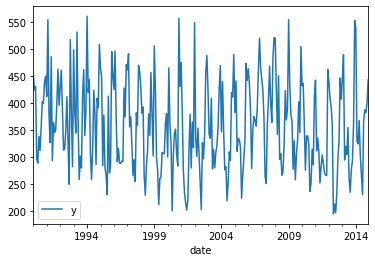

In [7]:
model.plotTimeSeries()

Si quieremos solo usar n cantidad de datos de nuestra serie de tiempo lo podemos hacer con el siguiente código. Por default agarra 400 y nuestra serie posee menos de 400 datos por lo que usará toda

<AxesSubplot:xlabel='date'>

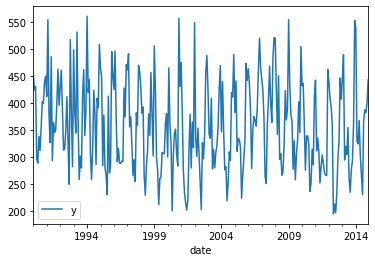

In [8]:
model.setTimeSeriesSlice()
model.plotTimeSeries()

Realizamos la grafica de ACF y PACF de nuestra serie de tiempo y observamos una clara temporalidad cada 6 y 12 meses, por lo que volvemos a graficar, pero en esta ocasion diferenciando

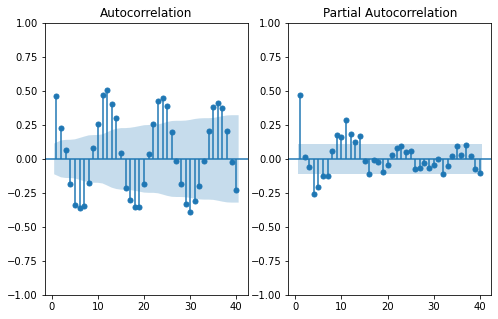

In [9]:
model.plot_acf_pacf(kwargs={'lags': 40})

Una vez diferenciada vemos que ya no parecería tener estacionalidad

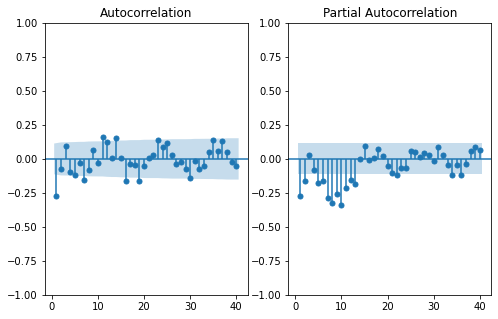

In [10]:
model.plot_acf_pacf(1, kwargs={'lags': 40})

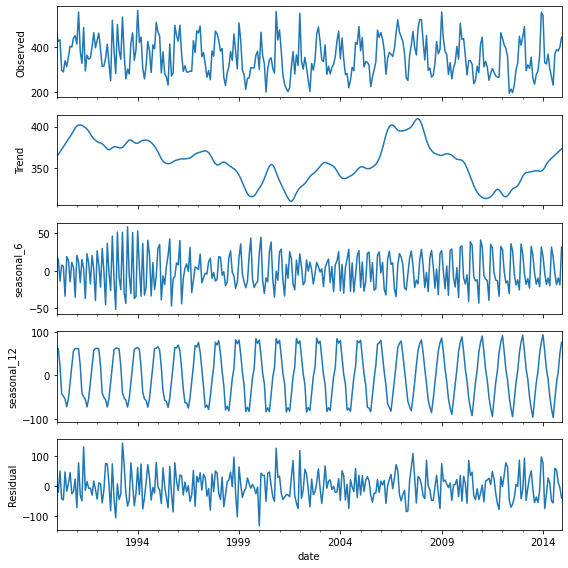

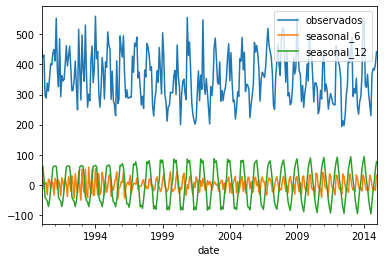

In [11]:
model.seasonalDecompose((6, 12))

seasonal_6 

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Non-differentiated


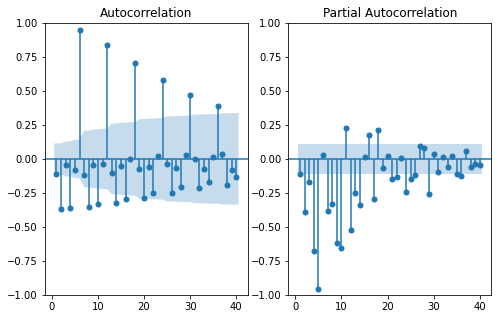

Differentiated


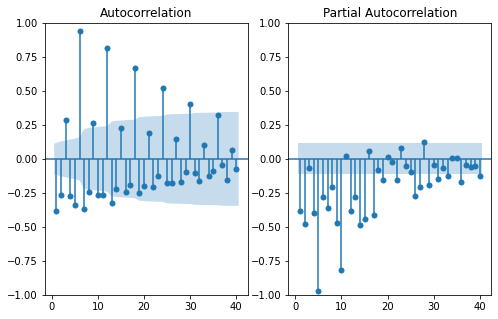





seasonal_12 

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Non-differentiated


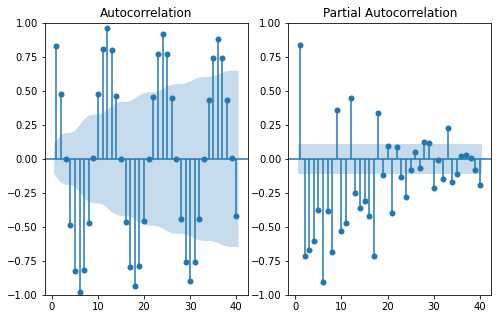

Differentiated


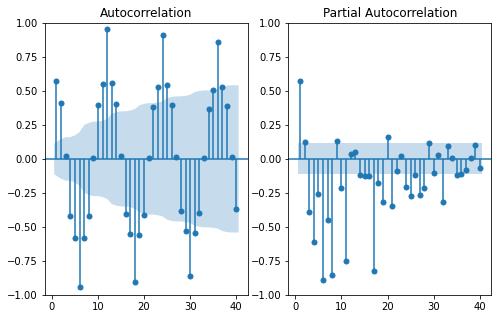

In [12]:
model.checkStationary()

Observamos que el componente no estacional no es estacionario, por lo que lo tendremos que diferenciar una vez para que si lo sea

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Non-differentiated


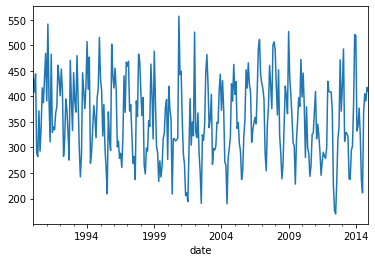

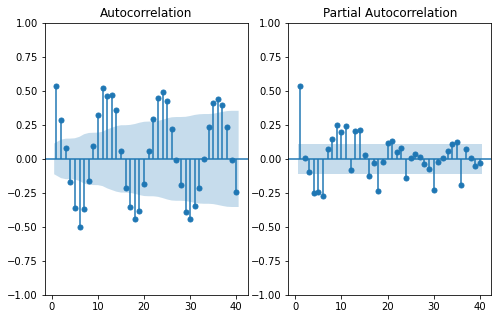

Differentiated


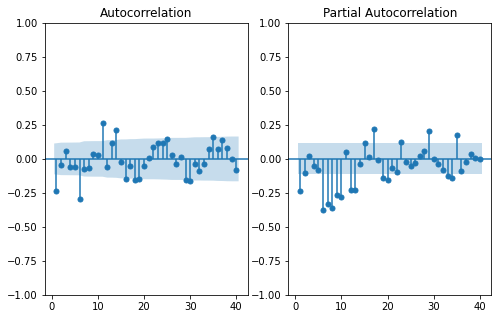

Differentiated x2


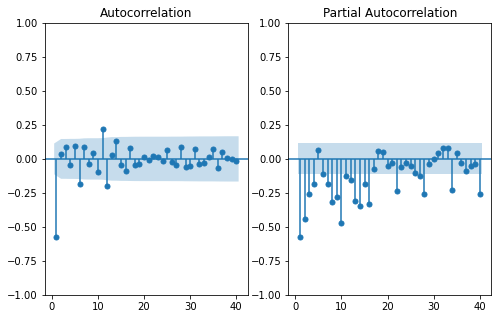

In [13]:
model.nonStationalComponent(6)

Ya diferenciado observamos que el componente no estacional ya es estacioanrio, por lo que ya tenemos nuestros posibles valores

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


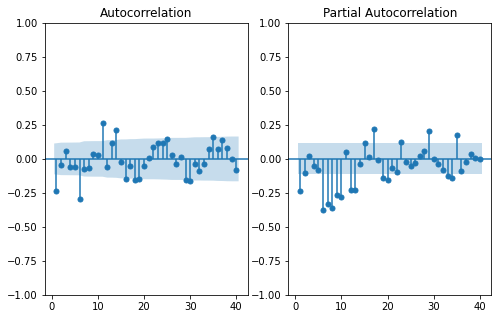

In [14]:
model.adf_test(False, model.non_seasonal.diff().dropna())
model.plot_acf_pacf(1, {'lags': 40}, False, model.non_seasonal)

Una vez teniendo nuestros posibles valores de (p, d, q)x(P, D, Q, S), creamos una lista con todas las combinaciones posibles y entrenamos modelos SARIMAX con estos para encontrar el mejor

In [15]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]
model.sarimaxParameters(p, d, q, P, D, Q)

In [16]:
posibleParams = model.findParams().sort_values(by=['AIC'], ascending=True)
posibleParams

Trying out 216 posible combinations
Model done for params: (0, 1, 0), (0, 0, 0, 6), n
Model done for params: (0, 1, 0), (0, 0, 0, 6), c
Model done for params: (0, 1, 0), (0, 0, 0, 6), t
Model done for params: (0, 1, 0), (0, 0, 0, 6), ct
Model done for params: (0, 1, 0), (0, 0, 1, 6), n
Model done for params: (0, 1, 0), (0, 0, 1, 6), c
Model done for params: (0, 1, 0), (0, 0, 1, 6), t
Model done for params: (0, 1, 0), (0, 0, 1, 6), ct
Model done for params: (0, 1, 0), (0, 0, 2, 6), n
Model done for params: (0, 1, 0), (0, 0, 2, 6), c
Model done for params: (0, 1, 0), (0, 0, 2, 6), t
Model done for params: (0, 1, 0), (0, 0, 2, 6), ct
Model done for params: (0, 1, 0), (1, 0, 0, 6), n
Model done for params: (0, 1, 0), (1, 0, 0, 6), c
Model done for params: (0, 1, 0), (1, 0, 0, 6), t
Model done for params: (0, 1, 0), (1, 0, 0, 6), ct
Model done for params: (0, 1, 0), (1, 0, 1, 6), n
Model done for params: (0, 1, 0), (1, 0, 1, 6), c
Model done for params: (0, 1, 0), (1, 0, 1, 6), t
Model done

,params,AIC,BIC,LLF
196,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.099955,707.302616,-336.549977
208,"((2, 1, 1), (2, 0, 1, 6), 'n')",686.686002,712.589107,-336.343001
200,"((2, 1, 1), (1, 0, 2, 6), 'n')",686.723048,712.626153,-336.361524
197,"((2, 1, 1), (1, 0, 1, 6), 'c')",686.900043,712.803148,-336.450021
140,"((1, 1, 1), (2, 0, 2, 6), 'n')",687.199022,713.102127,-336.599511
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",857.435144,868.536475,-425.717572
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",857.44472,868.546051,-425.72236
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",858.107435,869.208766,-426.053718
15,"((0, 1, 0), (1, 0, 0, 6), 'ct')",859.223207,874.024982,-425.611604


Una vez teniendo el mejor simplemente entrenamos un modelo SARIMA con esos parametros para que sea el modelo de la clase

In [17]:
model.sarimaxModel((2, 1, 1), (1, 0, 1, 6), 'n')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  300
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 6)   Log Likelihood                -328.149
Date:                           Thu, 16 Feb 2023   AIC                            668.298
Time:                                   13:21:18   BIC                            690.338
Sample:                                        0   HQIC                           677.127
                                           - 300                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0639      0.068      0.938      0.348      -0.070       0.198
ar.L2         -0.1164      0.063     -1.834      0.067      -0.241       0.008
ma.L1         -0.9151      0.033    -27.714      0.000      -0.980      -0.850
ar.S.L6       -1.0037      0.004   -233.357      0.000      -1.012      -0.995
ma.S.L6        1.0000    791.961      0.001      0.999   -1551.215    1553.215
sigma2         0.5137    406.809      0.001      0.999    -796.816     797.844
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.97   Prob(JB):                         0.35
Heteroskedasticity (H):               0.92   Skew:                             0.11
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A partir de este modelo podemos realizar predicciones y calcular errores

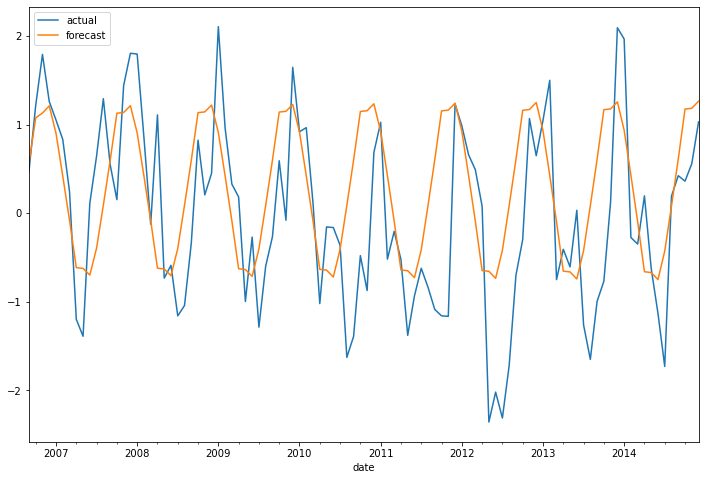

In [18]:
model.prediction(100)

In [19]:
model.errors()

MAPE: 170.53 
 MAD: 73.77


Código de solución estudiante 2

In [5]:
# Código de solución estudiante 2

import warnings
warnings.filterwarnings("ignore")

timeseries = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
timeseries.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [6]:
timeseries = timeseries.set_index("date").resample("M").mean()
timeseries = timeseries[["Energy (kWh)"]]
timeseries = timeseries.rename(columns={"Energy (kWh)":"y"})
timeseries

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006
...,...
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674


<AxesSubplot: xlabel='date'>

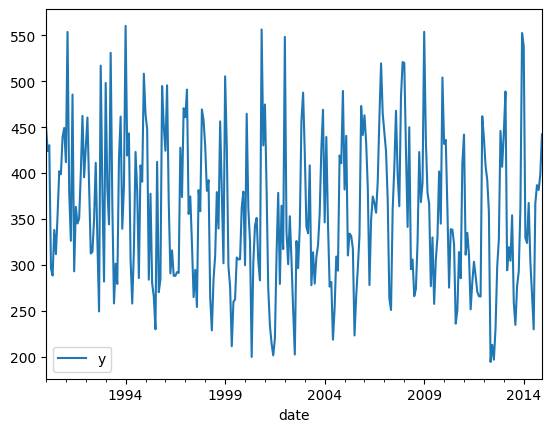

In [7]:
timeseries.plot()

In [8]:
modelo_timeseries = LinearForecast(timeseries)

In [9]:
# Vemos si los datos son estacionarios
modelo_timeseries.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


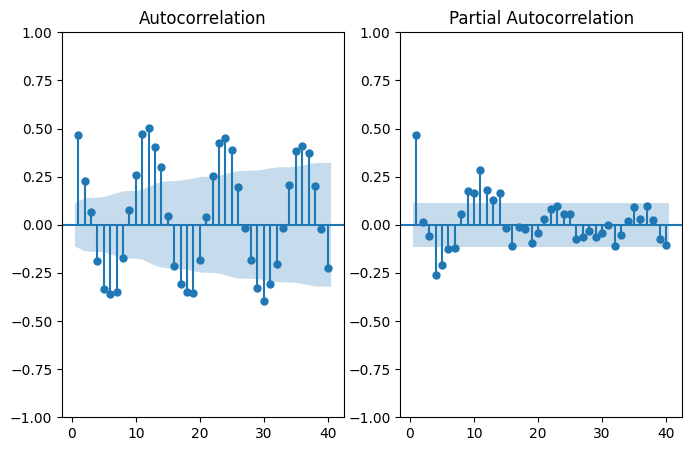

In [10]:
modelo_timeseries.plot_acf_pacf(kwargs={'lags': 40})

Parece que hay estacionalidad cada 6 y 12 meses.

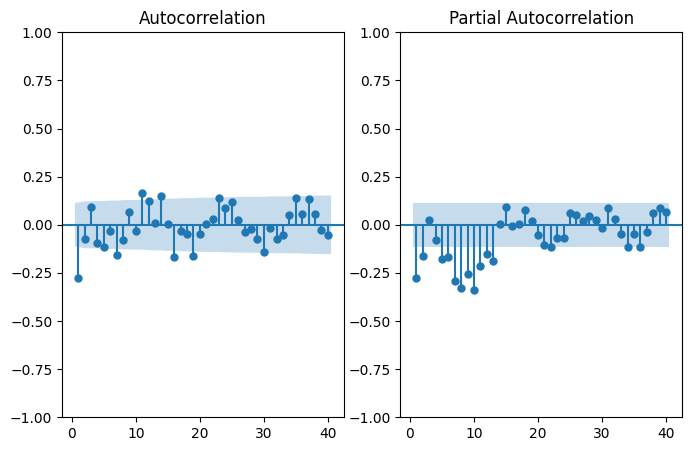

In [11]:
# Diferenciamos
modelo_diff = LinearForecast(timeseries.diff().dropna())
modelo_diff.plot_acf_pacf(kwargs={'lags': 40})

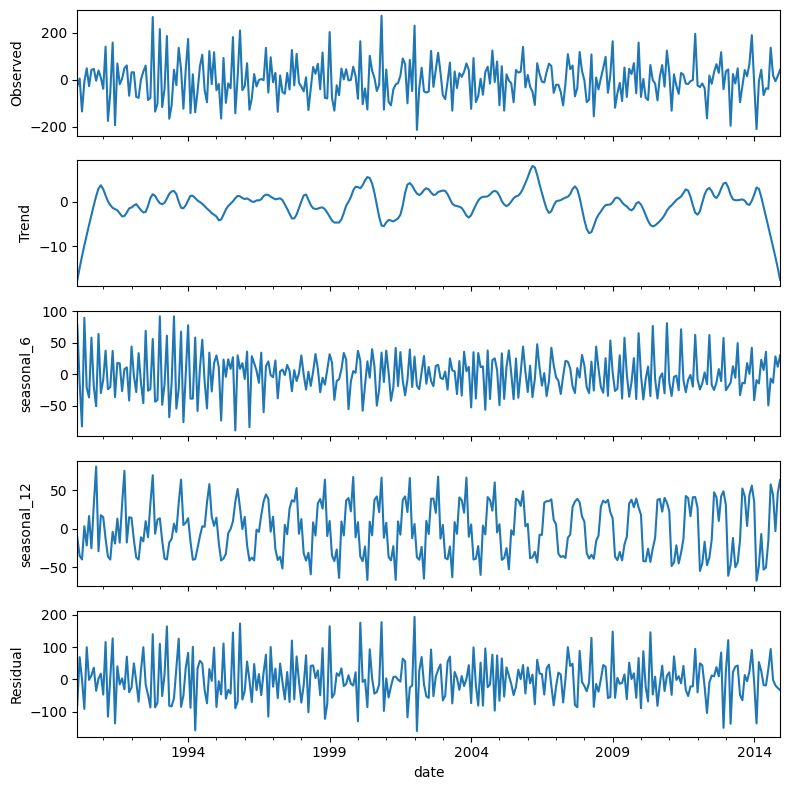

In [12]:
seasonal = modelo_diff.decompose_timeseries_mstl((6, 12), {})

<AxesSubplot: xlabel='date'>

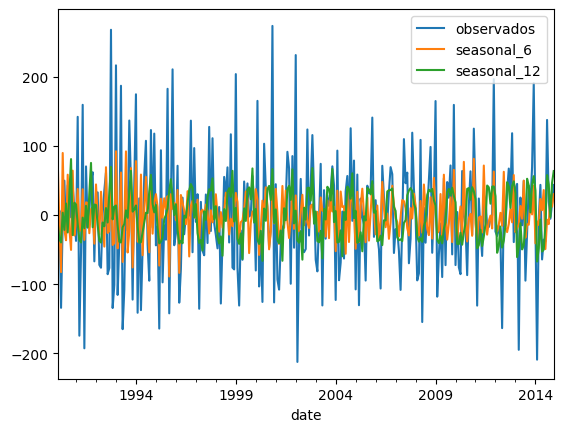

In [13]:
ax = seasonal.observed.to_frame('observados').plot()

seasonal.seasonal.plot(ax=ax)

In [14]:
modelo_diff.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


<AxesSubplot: xlabel='date'>

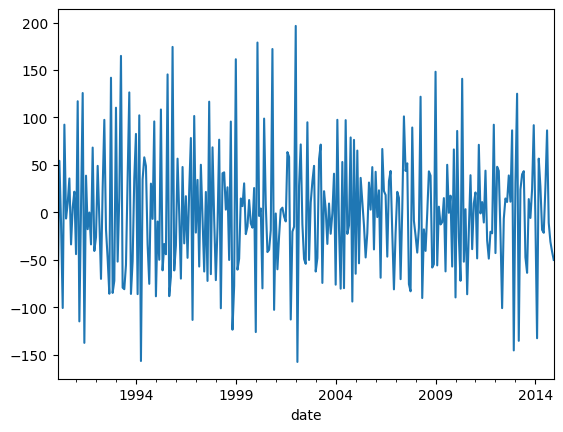

In [15]:
non_seasonal = seasonal.observed - seasonal.seasonal['seasonal_6'] - seasonal.seasonal['seasonal_12']
non_seasonal.plot()

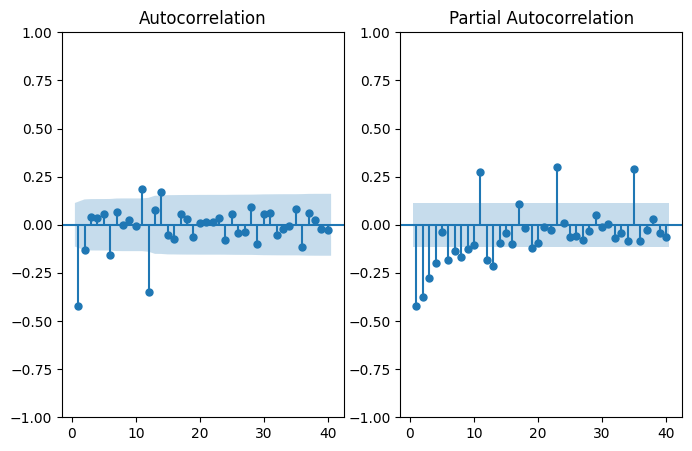

In [16]:
non_seasonal_f = LinearForecast(non_seasonal)
non_seasonal_f.plot_acf_pacf({'lags': 40})

In [17]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0, 1]
D = [0]
Q = [0, 1]
t = ['n', 'c', 't', 'ct']

params = non_seasonal_f.sarimax_params(p, d, q, P, D, Q, t, 6)
params

[((0, 1, 0), (0, 0, 0, 6), 'n'),
 ((0, 1, 0), (0, 0, 0, 6), 'c'),
 ((0, 1, 0), (0, 0, 0, 6), 't'),
 ((0, 1, 0), (0, 0, 0, 6), 'ct'),
 ((0, 1, 0), (0, 0, 1, 6), 'n'),
 ((0, 1, 0), (0, 0, 1, 6), 'c'),
 ((0, 1, 0), (0, 0, 1, 6), 't'),
 ((0, 1, 0), (0, 0, 1, 6), 'ct'),
 ((0, 1, 0), (1, 0, 0, 6), 'n'),
 ((0, 1, 0), (1, 0, 0, 6), 'c'),
 ((0, 1, 0), (1, 0, 0, 6), 't'),
 ((0, 1, 0), (1, 0, 0, 6), 'ct'),
 ((0, 1, 0), (1, 0, 1, 6), 'n'),
 ((0, 1, 0), (1, 0, 1, 6), 'c'),
 ((0, 1, 0), (1, 0, 1, 6), 't'),
 ((0, 1, 0), (1, 0, 1, 6), 'ct'),
 ((0, 1, 1), (0, 0, 0, 6), 'n'),
 ((0, 1, 1), (0, 0, 0, 6), 'c'),
 ((0, 1, 1), (0, 0, 0, 6), 't'),
 ((0, 1, 1), (0, 0, 0, 6), 'ct'),
 ((0, 1, 1), (0, 0, 1, 6), 'n'),
 ((0, 1, 1), (0, 0, 1, 6), 'c'),
 ((0, 1, 1), (0, 0, 1, 6), 't'),
 ((0, 1, 1), (0, 0, 1, 6), 'ct'),
 ((0, 1, 1), (1, 0, 0, 6), 'n'),
 ((0, 1, 1), (1, 0, 0, 6), 'c'),
 ((0, 1, 1), (1, 0, 0, 6), 't'),
 ((0, 1, 1), (1, 0, 0, 6), 'ct'),
 ((0, 1, 1), (1, 0, 1, 6), 'n'),
 ((0, 1, 1), (1, 0, 1, 6), 'c'),
 ((

In [18]:
train, test = non_seasonal_f.split_dataset(0.9)

In [19]:
res = non_seasonal_f.training_sarimax_multiple_params(train, params)

In [20]:
res.head(1)

,params,AIC,BIC,LLF
0,"((2, 1, 1), (1, 0, 1, 6), 'n')",2830.449967,2851.995889,-1409.224983


In [31]:
model = non_seasonal_f.sarimax_model(train, "n", (2, 1, 1), (1, 0, 1, 6))
resp = res.head(1)[["AIC", "BIC", "LLF"]]
resp

,AIC,BIC,LLF
0,2830.449967,2851.995889,-1409.224983
